In [511]:
edges = [
    ('A', 'r1', 'B'),
    ('B', 'r1', 'C'),
    ('D', 'r1', 'C'),
    ('A', 'r1', 'D'),
    ('A', 'r1', 'C'),
    ('A', 'r1', 'X'),
    ('A', 'r2', 'B'),
    ('B', 'r2', 'C'),
    ('D', 'r2', 'C'),
    ('A', 'r2', 'D'),
    ('A', 'r2', 'C'),
    ('A', 'r2', 'X'),
]

In [512]:
import networkx as nx
import pandas as pd
import random

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch.utils.data import DataLoader
from copy import deepcopy
import torch

random.seed(10)

In [513]:
df = pd.DataFrame(edges, columns=["head", "edge_type", "tail"])

In [514]:
df.head()

,head,edge_type,tail
0,A,r1,B
1,B,r1,C
2,D,r1,C
3,A,r1,D
4,A,r1,C


In [515]:
G = nx.from_pandas_edgelist(df, source="head", target="tail", edge_attr="edge_type", create_using=nx.MultiDiGraph())
# G = nx.from_pandas_edgelist(df, source="head", target="tail", edge_attr="edge_type", create_using=nx.DiGraph())

In [516]:
G.nodes()

NodeView(('A', 'B', 'C', 'D', 'X'))

In [517]:
G.edges()

OutMultiEdgeDataView([('A', 'B'), ('A', 'B'), ('A', 'D'), ('A', 'D'), ('A', 'C'), ('A', 'C'), ('A', 'X'), ('A', 'X'), ('B', 'C'), ('B', 'C'), ('D', 'C'), ('D', 'C')])

In [518]:
r1_score_list = []
for n1 in G.nodes():
    for n2 in G.nodes():
        r1_score_list.append((n1, n2, random.random()))

In [519]:
sorted(r1_score_list, key=lambda x: x[2], reverse=True)

[('C', 'C', 0.9965569925394552),
 ('X', 'X', 0.9824132490111909),
 ('C', 'B', 0.9528169091459117),
 ('C', 'X', 0.860161037286291),
 ('B', 'A', 0.8235888725334455),
 ('A', 'X', 0.81332125135732),
 ('X', 'D', 0.7678378139439905),
 ('X', 'A', 0.6858614854745947),
 ('D', 'D', 0.674964847134956),
 ('X', 'B', 0.6618463200523511),
 ('B', 'B', 0.6534725339011758),
 ('D', 'A', 0.603190610968185),
 ('A', 'C', 0.5780913011344704),
 ('A', 'A', 0.5714025946899135),
 ('B', 'D', 0.5206693596399246),
 ('D', 'X', 0.45683115105830563),
 ('A', 'B', 0.4288890546751146),
 ('D', 'B', 0.3816059859191179),
 ('B', 'X', 0.32777281162209315),
 ('D', 'C', 0.28361821790671515),
 ('C', 'A', 0.24999667668640035),
 ('A', 'D', 0.20609823213950174),
 ('B', 'C', 0.16022955651881965),
 ('X', 'C', 0.1329781447122128),
 ('C', 'D', 0.04455638245043303)]

In [520]:
g_edges = list(G.edges())

In [521]:
g_edges

[('A', 'B'),
 ('A', 'B'),
 ('A', 'D'),
 ('A', 'D'),
 ('A', 'C'),
 ('A', 'C'),
 ('A', 'X'),
 ('A', 'X'),
 ('B', 'C'),
 ('B', 'C'),
 ('D', 'C'),
 ('D', 'C')]

In [522]:
print(('A', 'B') in g_edges)
print(('A', 'C') in g_edges)

True
True


In [523]:
from linkpred.metrics import hits_at_k, mean_rank, mean_reciprocal_rank

print(hits_at_k(r1_score_list, g_edges, 1))
print(hits_at_k(r1_score_list, g_edges, 3))
print(hits_at_k(r1_score_list, g_edges, 4))
print(mean_rank(r1_score_list, g_edges))
print(mean_reciprocal_rank(r1_score_list, g_edges))

(0.0, 0)
(0.0, 0)
(0.0, 0)
16.833333333333332
0.07355767988760316


In [524]:
import matplotlib.pyplot as plt

In [525]:
from deepsnap.hetero_graph import HeteroGraph

In [526]:
nodes = G.nodes()
G.add_nodes_from(nodes, node_type="n1")

In [527]:
print("The graph has {} nodes and {} edges".format(G.number_of_nodes(), G.number_of_edges()))
pos = nx.spring_layout(G, seed=1)
plt.figure(figsize=(8, 8))
nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color="grey", connectionstyle='arc3, rad = 0.1')
plt.show()

The graph has 5 nodes and 12 edges


<IPython.core.display.Javascript object>

/opt/homebrew/Caskroom/miniconda/base/envs/linkpred/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(
/var/folders/9p/t8j1jsws445frpbtmwvphlnm0000gn/T/ipykernel_26754/1515228832.py:5: UserWarning: Matplotlib is currently using nbAgg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [528]:
task = 'link_pred'
dg = HeteroGraph(G)

print(dg.num_nodes())
print(dg.num_edges())

{'n1': 5}
{('n1', 'r1', 'n1'): 6, ('n1', 'r2', 'n1'): 6}


In [529]:
task = "link_pred"
dg = HeteroGraph(G)
# Transform to DeepSNAP dataset
dataset = GraphDataset([dg], task=task, edge_train_mode="disjoint")
print("Original DeepSNAP dataset has {} edges".format(dataset.num_edges[0]))

# Split the dataset
dataset_train, dataset_val, dataset_test = dataset.split(
            transductive=True, split_ratio=[0.8, 0.1, 0.1])

for edge_type in dataset[0].edge_label_index.keys():
    num_train_message_edges = dataset_train[0].edge_label_index[edge_type].shape[1]
    num_val_message_edges = dataset_val[0].edge_label_index[edge_type].shape[1]
    num_test_message_edges = dataset_test[0].edge_label_index[edge_type].shape[1]

    print("Train set has {} {} supervision (positive) edges".format(num_train_message_edges // 2, edge_type))
    print("Validation set has {} {} supervision (positive) edges".format(num_val_message_edges // 2, edge_type))
    print("Test set has {} {} supervision (positive) edges".format(num_test_message_edges // 2, edge_type))

    print("Train set has {} {} message passing edges".format(dataset_train[0].edge_index[edge_type].shape[1], edge_type))
    print("Validation set has {} {} message passing edges".format(dataset_val[0].edge_index[edge_type].shape[1], edge_type))
    print("Test set has {} {} message passing edges".format(dataset_test[0].edge_index[edge_type].shape[1], edge_type))

Original DeepSNAP dataset has <bound method HeteroGraph.num_edges of HeteroGraph(G=[], edge_index=[], edge_label_index=[], edge_to_graph_mapping=[], edge_to_tensor_mapping=[12], edge_type=[], negative_label_val=[1], node_label_index=[], node_to_graph_mapping=[], node_to_tensor_mapping=[5], node_type=[], task=[])> edges
Train set has 1 ('n1', 'r1', 'n1') supervision (positive) edges
Validation set has 1 ('n1', 'r1', 'n1') supervision (positive) edges
Test set has 2 ('n1', 'r1', 'n1') supervision (positive) edges
Train set has 2 ('n1', 'r1', 'n1') message passing edges
Validation set has 3 ('n1', 'r1', 'n1') message passing edges
Test set has 4 ('n1', 'r1', 'n1') message passing edges
Train set has 1 ('n1', 'r2', 'n1') supervision (positive) edges
Validation set has 1 ('n1', 'r2', 'n1') supervision (positive) edges
Test set has 2 ('n1', 'r2', 'n1') supervision (positive) edges
Train set has 2 ('n1', 'r2', 'n1') message passing edges
Validation set has 3 ('n1', 'r2', 'n1') message passing

In [530]:
from dataset import load_lnctard, df2nx

In [531]:
df = load_lnctard(cols=["Regulator", "Target", "SearchregulatoryMechanism"]); f"loaded dataset with {len(df)} samples"

'loaded dataset with 7438 samples'

In [532]:
df.head()

,Regulator,Target,SearchregulatoryMechanism
0,LINC00313,miR-4429,ceRNA or sponge
1,FAM83H-AS1,CDKN1A,epigenetic regulation
2,NEAT1,TGFB1,ceRNA or sponge
3,NEAT1,ZEB1,ceRNA or sponge
4,ZFPM2-AS1,MIF,interact with protein


In [533]:
df.rename({'SearchregulatoryMechanism': 'edge_type'}, axis=1, inplace=True)

In [534]:
df.head()

,Regulator,Target,edge_type
0,LINC00313,miR-4429,ceRNA or sponge
1,FAM83H-AS1,CDKN1A,epigenetic regulation
2,NEAT1,TGFB1,ceRNA or sponge
3,NEAT1,ZEB1,ceRNA or sponge
4,ZFPM2-AS1,MIF,interact with protein


In [535]:
# G_lnctard = df2nx(df, head="Regulator", tail="Target", creator=nx.MultiDiGraph(), relation="edge_type")
G_lnctard = nx.from_pandas_edgelist(df, source="Regulator", target="Target", edge_attr="edge_type", create_using=nx.MultiDiGraph())

In [536]:
print(G_lnctard.nodes())
print(len(G_lnctard.nodes()))
print(G_lnctard.edges())
print(len(G_lnctard.edges()))

['LINC00313', 'miR-4429', 'FAM83H-AS1', 'CDKN1A', 'NEAT1', 'TGFB1', 'ZEB1', 'ZFPM2-AS1', 'MIF', 'SNHG1', 'miR-448', 'IDO1', 'LINC00222', 'GSK3B', 'TP73-AS1', 'CASP3', 'CASP9', 'PVT1', 'miR-133a', 'FEZF1-AS1', 'PKM', 'DANCR', 'MMP9', 'HOTTIP', 'miR-216a-5p', 'PEG10', 'miR-3200', 'CCAT1', 'BMI1', 'GAS5', 'miR-301a', 'CCDC26', 'miR-203', 'CRNDE', 'LINC00858', 'CDK14', 'HOTAIR', 'HAGLR', 'TDRG1', 'VEGFA', 'LIFR-AS1', 'TNFAIP3', 'THORLNC', 'YAP1', 'LINC00339', 'FOXM1', 'NNT-AS1', 'miR-129-5p', 'CBR3-AS1', 'PHGDH', 'RUNX3', 'ZEB2-AS1', 'HMGB1', 'FUNDC2P4', 'CDH1', 'SNHG12', 'ELAVL1', 'LNCRNA-ATB', 'CYTOR', 'NRP1', 'MALAT1', 'STAT3', 'SNHG5', 'CASP1', 'FOXP4-AS1', 'LATS1', 'TUG1', 'miR-29c', 'miR-126', 'SP1', 'PANDAR', 'STAT1', 'LINC00174', 'TAZ', 'EZH2', 'miR-196a-5p', 'MIR22HG', 'DAPK1', 'MEG3', 'miR-21', 'MIAT', 'SOX21-AS1', 'DICER1-AS1', 'ATG5', 'CASC15', 'miR-33a-5p', 'FOXO1', 'RP11-838N2.4', 'FTX', 'PPARG', 'MIR31HG', 'miR-31', 'BTG3-AS1', 'CASC2', 'miR-24-3p', 'TFAP4', 'TRERNA1', 'SMAD

In [537]:
G_lnctard_lcc = G_lnctard.subgraph(max(nx.weakly_connected_components(G_lnctard), key=len)).copy()

In [538]:
print(G_lnctard_lcc.nodes())
print(len(G_lnctard_lcc.nodes()))
print(G_lnctard_lcc.edges())
print(len(G_lnctard_lcc.edges()))

['LINC00313', 'miR-4429', 'FAM83H-AS1', 'CDKN1A', 'NEAT1', 'TGFB1', 'ZEB1', 'ZFPM2-AS1', 'MIF', 'SNHG1', 'miR-448', 'IDO1', 'LINC00222', 'GSK3B', 'TP73-AS1', 'CASP3', 'CASP9', 'PVT1', 'miR-133a', 'FEZF1-AS1', 'PKM', 'DANCR', 'MMP9', 'HOTTIP', 'miR-216a-5p', 'PEG10', 'miR-3200', 'CCAT1', 'BMI1', 'GAS5', 'miR-301a', 'CCDC26', 'miR-203', 'CRNDE', 'LINC00858', 'CDK14', 'HOTAIR', 'HAGLR', 'TDRG1', 'VEGFA', 'LIFR-AS1', 'TNFAIP3', 'THORLNC', 'YAP1', 'LINC00339', 'FOXM1', 'NNT-AS1', 'miR-129-5p', 'CBR3-AS1', 'PHGDH', 'RUNX3', 'ZEB2-AS1', 'HMGB1', 'FUNDC2P4', 'CDH1', 'SNHG12', 'ELAVL1', 'LNCRNA-ATB', 'CYTOR', 'NRP1', 'MALAT1', 'STAT3', 'SNHG5', 'CASP1', 'FOXP4-AS1', 'LATS1', 'TUG1', 'miR-29c', 'miR-126', 'SP1', 'PANDAR', 'STAT1', 'LINC00174', 'TAZ', 'EZH2', 'miR-196a-5p', 'MIR22HG', 'DAPK1', 'MEG3', 'miR-21', 'MIAT', 'SOX21-AS1', 'DICER1-AS1', 'ATG5', 'CASC15', 'miR-33a-5p', 'FOXO1', 'RP11-838N2.4', 'FTX', 'PPARG', 'MIR31HG', 'miR-31', 'BTG3-AS1', 'CASC2', 'miR-24-3p', 'TFAP4', 'TRERNA1', 'SMAD

In [539]:
nodes = G_lnctard_lcc.nodes()
G_lnctard_lcc.add_nodes_from(nodes, node_type="n1")

In [540]:
task = "link_pred"
dg = HeteroGraph(G_lnctard_lcc)

print(dg.num_nodes())
print(dg.num_edges())

{'n1': 3367}
{('n1', 'ceRNA or sponge', 'n1'): 3157, ('n1', 'transcriptional regulation', 'n1'): 548, ('n1', 'epigenetic regulation', 'n1'): 393, ('n1', 'interact with protein', 'n1'): 572, ('n1', 'expression association', 'n1'): 2405, ('n1', 'interact with mRNA', 'n1'): 60, ('n1', 'chromatin looping', 'n1'): 9}


In [597]:
dataset = GraphDataset([dg], task=task, edge_train_mode="disjoint", edge_negative_sampling_ratio=2)

# Split the dataset
dataset_train, dataset_val, dataset_test = dataset.split(
            transductive=True, split_ratio=[0.8, 0.1, 0.1])

for edge_type in dataset[0].edge_label_index.keys():
    num_train_message_edges = dataset_train[0].edge_label_index[edge_type].shape[1]
    num_val_message_edges = dataset_val[0].edge_label_index[edge_type].shape[1]
    num_test_message_edges = dataset_test[0].edge_label_index[edge_type].shape[1]

    print("Train set has {} {} supervision (positive) edges".format(num_train_message_edges // 2, edge_type))
    print("Validation set has {} {} supervision (positive) edges".format(num_val_message_edges // 2, edge_type))
    print("Test set has {} {} supervision (positive) edges".format(num_test_message_edges // 2, edge_type))

    print("Train set has {} {} message passing edges".format(dataset_train[0].edge_index[edge_type].shape[1], edge_type))
    print("Validation set has {} {} message passing edges".format(dataset_val[0].edge_index[edge_type].shape[1], edge_type))
    print("Test set has {} {} message passing edges".format(dataset_test[0].edge_index[edge_type].shape[1], edge_type))


Train set has 757 ('n1', 'ceRNA or sponge', 'n1') supervision (positive) edges
Validation set has 472 ('n1', 'ceRNA or sponge', 'n1') supervision (positive) edges
Test set has 475 ('n1', 'ceRNA or sponge', 'n1') supervision (positive) edges
Train set has 2020 ('n1', 'ceRNA or sponge', 'n1') message passing edges
Validation set has 2525 ('n1', 'ceRNA or sponge', 'n1') message passing edges
Test set has 2840 ('n1', 'ceRNA or sponge', 'n1') message passing edges
Train set has 132 ('n1', 'transcriptional regulation', 'n1') supervision (positive) edges
Validation set has 81 ('n1', 'transcriptional regulation', 'n1') supervision (positive) edges
Test set has 84 ('n1', 'transcriptional regulation', 'n1') supervision (positive) edges
Train set has 350 ('n1', 'transcriptional regulation', 'n1') message passing edges
Validation set has 438 ('n1', 'transcriptional regulation', 'n1') message passing edges
Test set has 492 ('n1', 'transcriptional regulation', 'n1') message passing edges
Train set h

In [598]:
num_nodes = sum(dataset[0].num_nodes().values())
num_train_nodes = sum(dataset_train[0].num_nodes().values())
num_val_nodes = sum(dataset_val[0].num_nodes().values())
num_test_nodes = sum(dataset_test[0].num_nodes().values())

print(f"Node statistics:")
print(f"num_nodes: {num_nodes}")
print(f"num_train_nodes: {num_train_nodes}  | {num_train_nodes / num_nodes * 100:.2f}%")
print(f"num_val_nodes: {num_val_nodes}  | {num_val_nodes / num_nodes * 100:.2f}%")
print(f"num_test_nodes: {num_test_nodes}  | {num_test_nodes / num_nodes * 100:.2f}%")

num_edges = sum(dataset[0].num_edges().values())
num_train_message_edges = sum(dataset_train[0].num_edges().values())
num_val_message_edges = sum(dataset_val[0].num_edges().values())
num_test_message_edges = sum(dataset_test[0].num_edges().values())

print(f"\nMessage passing edges statistics:")
print(f"num_edges: {num_edges}")
print(f"num_train_edges: {num_train_message_edges}  | {num_train_message_edges / num_edges * 100:.2f}%")
print(f"num_val_edges: {num_val_message_edges}  | {num_val_message_edges / num_edges * 100:.2f}%")
print(f"num_test_edges: {num_test_message_edges}  | {num_test_message_edges / num_edges * 100:.2f}%")

num_train_supervision_edges = sum([torch.count_nonzero(matrix) for matrix in dataset_train[0].edge_label.values()])
num_val_supervision_edges = sum([torch.count_nonzero(matrix) for matrix in dataset_val[0].edge_label.values()])
num_test_supervision_edges = sum([torch.count_nonzero(matrix) for matrix in dataset_test[0].edge_label.values()])

print(f"\nPositive supervision edges statistics:")
print(f"num_train_supervision_edges: {num_train_supervision_edges}  | {num_train_supervision_edges / num_edges * 100:.2f}%")
print(f"num_val_supervision_edges: {num_val_supervision_edges}  | {num_val_supervision_edges / num_edges * 100:.2f}%")
print(f"num_test_supervision_edges: {num_test_supervision_edges}  | {num_test_supervision_edges / num_edges * 100:.2f}%")

num_neg_train_edges = sum([matrix.shape[0] - torch.count_nonzero(matrix) for matrix in dataset_train[0].edge_label.values()])
num_neg_val_edges = sum([matrix.shape[0] - torch.count_nonzero(matrix) for matrix in dataset_val[0].edge_label.values()])
num_neg_test_edges = sum([matrix.shape[0] - torch.count_nonzero(matrix) for matrix in dataset_test[0].edge_label.values()])

print(f"\nNegative supervision edges statistics:")
print(f"num_neg_train_edges: {num_neg_train_edges}  | {num_neg_train_edges / num_edges * 100:.2f}%")
print(f"num_neg_val_edges: {num_neg_val_edges}  | {num_neg_val_edges / num_edges * 100:.2f}%")
print(f"num_neg_test_edges: {num_neg_test_edges}  | {num_neg_test_edges / num_edges * 100:.2f}%")

print(f"\nComplete (true) edges statistics:")
print(f"num_train_edges: {num_train_message_edges + num_train_supervision_edges}  | {(num_train_message_edges + num_train_supervision_edges) / num_edges * 100:.2f}%")
print(f"num_val_edges: {num_val_message_edges + num_val_supervision_edges}  | {(num_val_message_edges + num_val_supervision_edges) / num_edges * 100:.2f}%")
print(f"num_test_edges: {num_test_message_edges + num_test_supervision_edges}  | {(num_test_message_edges + num_test_supervision_edges) / num_edges * 100:.2f}%")

Node statistics:
num_nodes: 3367
num_train_nodes: 3367  | 100.00%
num_val_nodes: 3367  | 100.00%
num_test_nodes: 3367  | 100.00%

Message passing edges statistics:
num_edges: 7144
num_train_edges: 4567  | 63.93%
num_val_edges: 5711  | 79.94%
num_test_edges: 6423  | 89.91%

Positive supervision edges statistics:
num_train_supervision_edges: 1144  | 16.01%
num_val_supervision_edges: 712  | 9.97%
num_test_supervision_edges: 721  | 10.09%

Negative supervision edges statistics:
num_neg_train_edges: 2288  | 32.03%
num_neg_val_edges: 1424  | 19.93%
num_neg_test_edges: 1442  | 20.18%

Complete (true) edges statistics:
num_train_edges: 5711  | 79.94%
num_val_edges: 6423  | 89.91%
num_test_edges: 7144  | 100.00%


In [599]:
dataset_train[0]

HeteroGraph(G=[], edge_index=[], edge_label=[], edge_label_index=[], edge_to_graph_mapping=[], edge_to_tensor_mapping=[4567], edge_type=[], negative_label_val=[1], node_label_index=[], node_to_graph_mapping=[], node_to_tensor_mapping=[3367], node_type=[])

In [600]:
dataset_train[0].edge_label[('n1', 'ceRNA or sponge', 'n1')].shape

torch.Size([1515])

In [601]:
dataset_train[0].edge_label_index[('n1', 'ceRNA or sponge', 'n1')].shape

torch.Size([2, 1515])

In [602]:
dataset_train[0].edge_to_tensor_mapping.shape

torch.Size([4567])

In [603]:
dataset_train[0].edge_index[('n1', 'ceRNA or sponge', 'n1')].shape

torch.Size([2, 2020])

In [604]:
dataset_train[0].edge_to_graph_mapping[('n1', 'ceRNA or sponge', 'n1')].shape

torch.Size([2020])

In [605]:
dir(dataset_train[0].G)

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adj',
 '_node',
 '_pred',
 '_succ',
 'add_edge',
 'add_edges_from',
 'add_node',
 'add_nodes_from',
 'add_weighted_edges_from',
 'adj',
 'adjacency',
 'adjlist_inner_dict_factory',
 'adjlist_outer_dict_factory',
 'clear',
 'clear_edges',
 'copy',
 'degree',
 'edge_attr_dict_factory',
 'edge_key_dict_factory',
 'edge_subgraph',
 'edges',
 'get_edge_data',
 'graph',
 'graph_attr_dict_factory',
 'has_edge',
 'has_node',
 'has_predecessor',
 'has_successor',
 'in_degree',
 'in_edges',
 'is_directed',
 'is_multigraph',
 'name',
 'nbunch_iter',
 'neig

In [606]:
dataset_train[0].G.number_of_edges()

4567

In [607]:
dataset_train[0].G.number_of_nodes()

3367

In [608]:
dataset_train[0].G.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

In [609]:
nx.is_weakly_connected(dataset_train[0].G)

False

In [610]:
nx.is_weakly_connected(dataset[0].G)

True

In [611]:
nx.is_weakly_connected(dataset_val[0].G)

False

In [612]:
%matplotlib inline

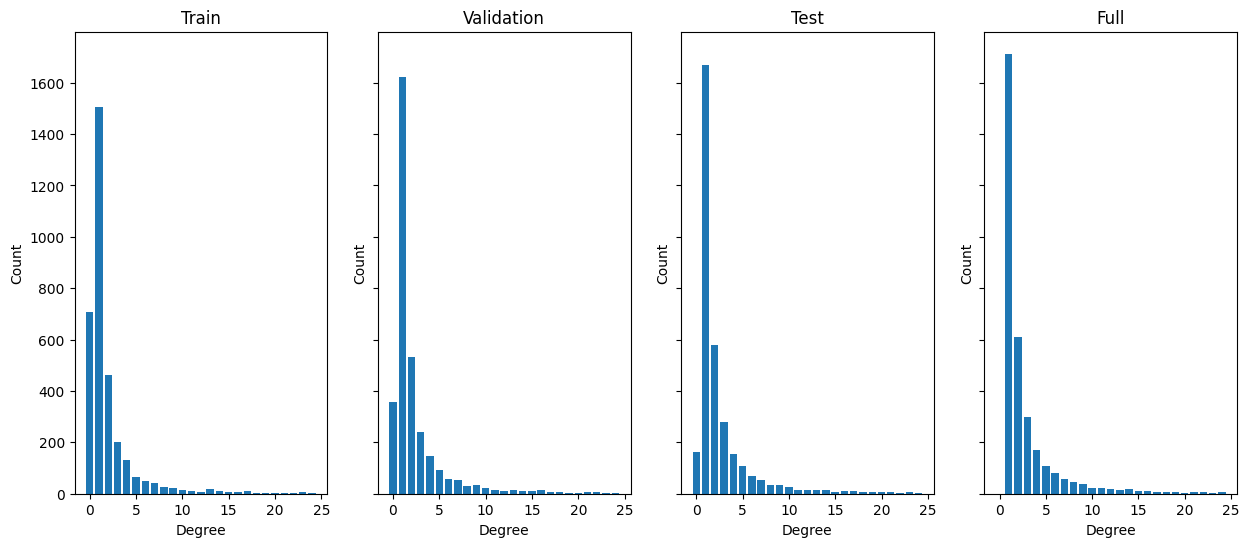

In [613]:
fig, axs = plt.subplots(ncols=4, figsize=(15,6), sharey=True)
title = ["Train", "Validation", "Test", "Full"]
for i, split in enumerate([dataset_train, dataset_val, dataset_test, dataset]):
    degrees = nx.degree_histogram(split[0].G)
    axs[i].bar(range(25), degrees[:25])
    axs[i].set_title(f"{title[i]}")
    axs[i].set_xlabel("Degree")
    axs[i].set_ylabel("Count")